# PumpItUp
## DrivenDataCompetition PumpItUp
- All data is within the same folder

In [1]:
import pandas as pd
import matplotlib as plt
import sklearn
import seaborn as sns

In [24]:
# load training-data and labels
trainingValues = pd.read_csv('4910797b-ee55-40a7-8668-10efd5c1b960.csv')
trainingLabels = pd.read_csv('0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')
trainingData = pd.merge(trainingValues, trainingLabels, on= 'id')

# First investigation on data
Possible data-issues
* population == 0 -> Delete all lines with population == 0
* num_private Not in feature-description -> check what to do with it

In [25]:
trainingData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [26]:
trainingData = trainingData[trainingData.population != 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional


In [27]:
#change labels to category data TODO: move to function
trainingData['status_group_cat'] = trainingData['status_group'].astype('category')
trainingData['quality_group_cat'] = trainingData['quality_group'].astype('category')
trainingData['quantity_cat'] = trainingData['quantity'].astype('category')
trainingData['source_cat'] = trainingData['source'].astype('category')
trainingData['source_type_cat'] = trainingData['source_type'].astype('category')
trainingData['source_class_cat'] = trainingData['source_class'].astype('category')
trainingData['waterpoint_type'] = trainingData['waterpoint_type'].astype('category')
trainingData['waterpoint_type_group_cat'] = trainingData['waterpoint_type_group'].astype('category')

cat_columns = trainingData.select_dtypes(['category']).columns

trainingData[cat_columns] = trainingData[cat_columns].apply(lambda x: x.cat.codes)

In [28]:
trainingData.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,waterpoint_type,waterpoint_type_group,status_group,status_group_cat,quality_group_cat,quantity_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_group_cat
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,1,communal standpipe,functional,0,2,1,8,6,0,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,1,communal standpipe,functional,0,2,2,5,3,1,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,2,communal standpipe,functional,0,2,1,0,1,1,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,2,communal standpipe,non functional,2,2,0,3,0,0,1
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587,Tajiri,0,...,2,communal standpipe,functional,0,4,1,4,2,2,1


In [29]:
trainingData.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,waterpoint_type,status_group_cat,quality_group_cat,quantity_cat,source_cat,source_type_cat,source_class_cat,waterpoint_type_group_cat
count,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000,38019.000000
mean,37107.559115,447.787681,969.889634,36.074387,-6.139781,0.740788,16.076988,6.299456,281.087167,1961.399721,2.362266,0.829217,2.274757,1.335122,6.011494,3.877298,0.262553,1.905047
std,21406.803661,3706.770967,612.544787,2.586779,2.737733,15.288297,21.597996,11.303334,564.687660,263.994165,1.762964,0.950787,0.794264,0.763660,2.053367,2.268178,0.453973,1.368417
min,1.000000,0.000000,-90.000000,29.607122,-11.649440,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18514.500000,0.000000,347.000000,34.715340,-8.388839,0.000000,4.000000,2.000000,40.000000,1986.000000,1.000000,0.000000,2.000000,1.000000,5.000000,3.000000,0.000000,1.000000
50%,37128.000000,0.000000,1135.000000,36.706815,-5.750877,0.000000,10.000000,3.000000,150.000000,2000.000000,1.000000,0.000000,2.000000,1.000000,7.000000,5.000000,0.000000,1.000000
75%,55505.500000,100.000000,1465.000000,37.940149,-3.597016,0.000000,16.000000,5.000000,324.000000,2008.000000,4.000000,2.000000,2.000000,2.000000,8.000000,6.000000,1.000000,3.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-1.042375,1776.000000,99.000000,67.000000,30500.000000,2013.000000,6.000000,2.000000,5.000000,4.000000,9.000000,6.000000,2.000000,5.000000


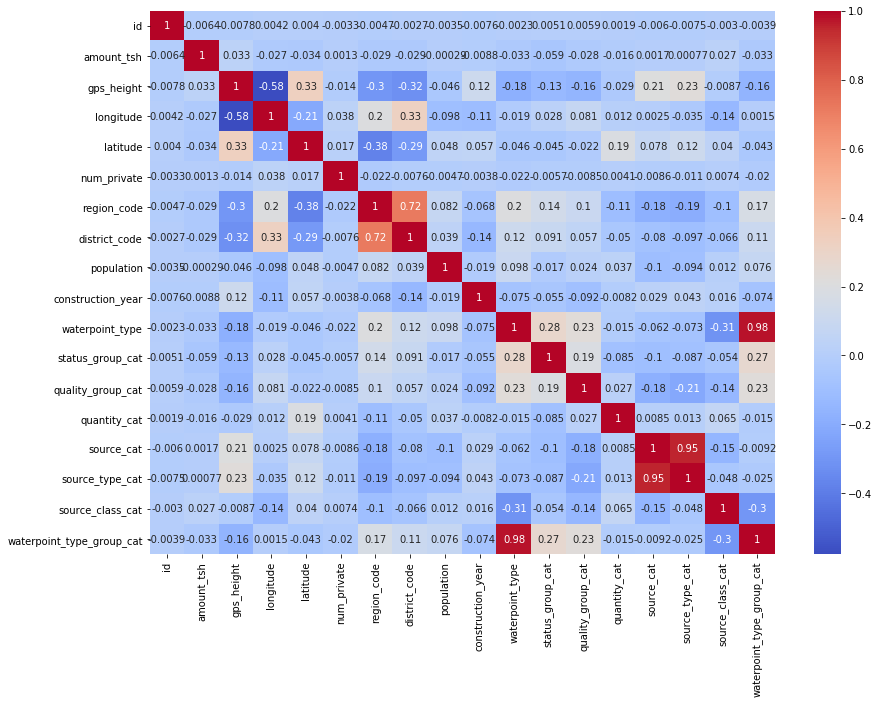

In [30]:
#check correlation
fig = plt.pyplot.gcf()
fig.set_size_inches(14,10)
sns.heatmap(trainingData.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
# Try random forest